In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
label_def_similar = {'background': 0, 'f/s20/40_20/40_B/G': 1, 'm20_100': 2, 'm20/30': 3, 'r20': 4, 
             'bearing_box': 5, 'bearing': 6, 'axis': 7, 'distance_tube': 8, 'motor': 9, 
             'container': 10, 'em_01': 11, 'em_02': 12}

label_def_full = {'background': 0, 'f20_20_B': 1, 's40_40_B': 2, 'f20_20_G': 3, 's40_40_G': 4,  
             'm20_100': 5, 'm20': 6, 'm30': 7, 'r20': 8, 'bearing_box_ax01': 9, 'bearing': 10, 'axis': 11, 
             'distance_tube': 12, 'motor': 13, 'container_box_blue': 14, 'container_box_red': 15, 
             'bearing_box_ax16': 16, 'em_01': 17, 'em_02': 18}

label_def_size_invariant = {'background': 0, 'f/s20/40_20/40_B': 1, 'f/s20/40_20/40_G': 2,
                            'm20_100': 3, 'm20/30': 4, 'r20': 5, 'bearing_box': 6, 
                            'bearing': 7, 'axis': 8, 'distance_tube': 9, 'motor': 10, 'container_box_blue': 11, 
                            'container_box_red': 12, 'em_01': 13, 'em_02': 14}

label_def_binary = {'background': 0, 'foreground': 1}

variant_to_label_def = {'full': label_def_full, 'binary': label_def_binary,
                                     'similar': label_def_similar, 
                                     'size_invariant': label_def_size_invariant}

In [3]:
class DataAnalysis():
    
    def __init__(self, VARIANT='full', LABEL_PATH='./real_augmented/training/label'):
        
        self.variant = VARIANT
        self.label_path = LABEL_PATH
        self.label_def = variant_to_label_def[VARIANT]
        
        file_paths = self.read_labels()
        self.image_to_cls_to_pixelCount = self.initialize_data_dict()
        self.total_pixels = self.get_total_pixels(file_paths)
        self.populate_data_dict(file_paths)
    
    def read_labels(self):
            
        return [os.path.join(self.label_path, file) for file in
               os.listdir(self.label_path)]
    
    def initialize_data_dict(self):
        
        image_to_cls_to_pixelCount = {}
        cls_to_pixelCount = {key:0 for key in range(len(self.label_def))}
        for file in os.listdir(self.label_path):
            image_to_cls_to_pixelCount[file] = cls_to_pixelCount.copy()
            
        return image_to_cls_to_pixelCount
    
    def get_total_pixels(self, file_paths):
        
        img_dimension = cv2.imread(file_paths[0], 0).shape
        return img_dimension[0]*img_dimension[1]*len(file_paths)
    
    def populate_data_dict(self, file_paths):
        
        for file in file_paths:
            img = cv2.imread(file, 0)
            clses = np.unique(img)
            img_name = file.split('/')[-1]

            for cls in clses:      
                self.image_to_cls_to_pixelCount[img_name][cls] = np.shape(
                                                        np.argwhere(img==cls))[0]

            if sum(self.image_to_cls_to_pixelCount[img_name].values()
                                      ) != img.shape[0]*img.shape[1]:
                raise ValueError('Not all pixels have been counted...')
                
    def get_cls_to_percentage(self):
        
        cls_to_percentage = {key:0 for key in self.label_def.keys()}
        for count_dict in self.image_to_cls_to_pixelCount.values():
            for key in cls_to_percentage.keys():
                cls_to_percentage[key] += count_dict.get(self.label_def[key], 0)

        return {key:(value/self.total_pixels)*100 for key, value in 
                                            cls_to_percentage.items()}
    
    def plot_cls_to_x(self, cls_to_x, y_label):
        
        figure = plt.figure(figsize=(15, 5))
        plt.bar(cls_to_x.keys(), cls_to_x.values())
        plt.xlabel('class name', fontsize= 20)
        plt.ylabel(y_label, fontsize= 20)
        plt.title('VARIANT: {}'.format(self.variant),
                 fontsize= 20)
        plt.xticks(rotation=80)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.show()
        
    def get_cls_to_weight(self, cls_to_percentage, set_background_weight=None):
        
        cls_to_weight = {key: round(len(self.label_def)/(100*value),4)
                         for key, value in cls_to_percentage.items()}

        normalizer = sum(cls_to_weight.values()) - cls_to_weight['background']
        
        if set_background_weight is None:
            background_weight = cls_to_weight['background']  
        else:
            background_weight = set_background_weight

        cls_to_weight = {key: round(value*(1 - background_weight)/normalizer, 4) 
                         if key is not 'background'
                        else background_weight for key, value in cls_to_weight.items()}

        if 1. - sum(cls_to_weight.values()) > 1e-10:
            raise ValueError (
                'The sum of weights is {}... The weights have not been normalized...'.
                format(sum(cls_to_weight.values())))

        return cls_to_weight
    
    def get_weight_list(self, cls_to_weight):
        
        weight_list = np.zeros(len(self.label_def))
        for label in self.label_def.keys():
            weight_list[self.label_def[label]] = cls_to_weight[label]

        return list(weight_list)
    
    def get_cls_to_count(self, cls_to_weight):
        
        cls_to_count = {key:0 for key in range(len(self.label_def))}
        for count_dict in self.image_to_cls_to_pixelCount.values():
            cls_to_count = {key: value + 1 if count_dict[key]!=0 
                            else value for key, value in cls_to_count.items()}
            
        cls_to_count = {key: cls_to_count[self.label_def[key]] for 
                        key in cls_to_weight.keys()}
            
        return cls_to_count

In [4]:
analyzer = DataAnalysis(VARIANT='full', LABEL_PATH='./real_augmented/training/label')

Percentage of pixels occupied by each class: 

{'background': 87.88899735243055, 'f20_20_B': 0.3129019965277778, 's40_40_B': 0.4096455729166667, 'f20_20_G': 0.27324340277777776, 's40_40_G': 0.6471757378472223, 'm20_100': 0.5276860243055556, 'm20': 0.250877734375, 'm30': 0.23578919270833332, 'r20': 0.2677448784722222, 'bearing_box_ax01': 0.7868705729166666, 'bearing': 0.18473910590277778, 'axis': 0.30401085069444445, 'distance_tube': 0.05724079861111111, 'motor': 0.7381453559027777, 'container_box_blue': 2.1301194010416666, 'container_box_red': 1.927945095486111, 'bearing_box_ax16': 0.3955670572916667, 'em_01': 1.1154346354166667, 'em_02': 1.5458652343750001}


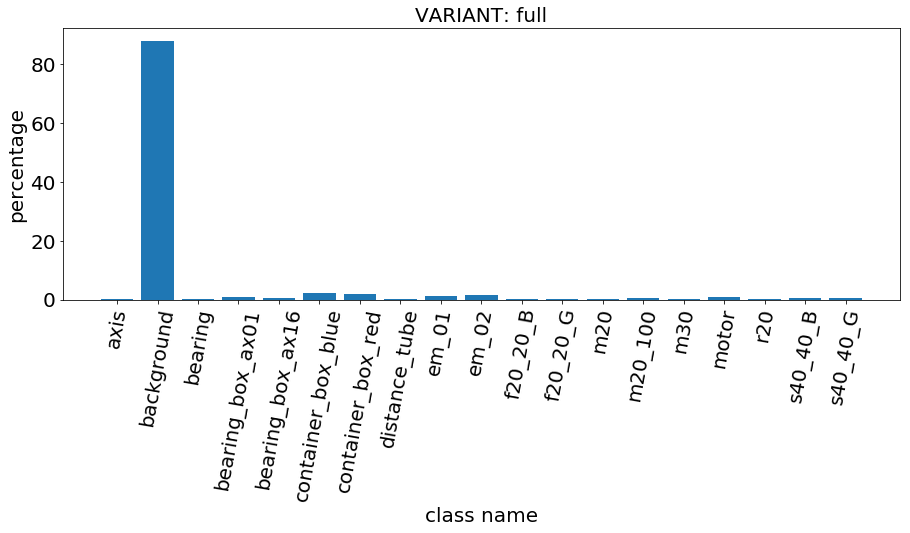

In [5]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: ')
print ()
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

Calculated weight coefficient of each class: 

{'background': 0.0022, 'f20_20_B': 0.0545, 's40_40_B': 0.0416, 'f20_20_G': 0.0624, 's40_40_G': 0.0263, 'm20_100': 0.0323, 'm20': 0.0679, 'm30': 0.0723, 'r20': 0.0636, 'bearing_box_ax01': 0.0217, 'bearing': 0.0922, 'axis': 0.0561, 'distance_tube': 0.2977, 'motor': 0.0231, 'container_box_blue': 0.008, 'container_box_red': 0.0088, 'bearing_box_ax16': 0.0431, 'em_01': 0.0153, 'em_02': 0.011}

List of weights:  [0.0022, 0.0545, 0.0416, 0.0624, 0.0263, 0.0323, 0.0679, 0.0723, 0.0636, 0.0217, 0.0922, 0.0561, 0.2977, 0.0231, 0.008, 0.0088, 0.0431, 0.0153, 0.011]

List of weights obtained by calling DataAnalysis():  [0.0022, 0.0545, 0.0416, 0.0624, 0.0263, 0.0323, 0.0679, 0.0723, 0.0636, 0.0217, 0.0922, 0.0561, 0.2977, 0.0231, 0.008, 0.0088, 0.0431, 0.0153, 0.011]


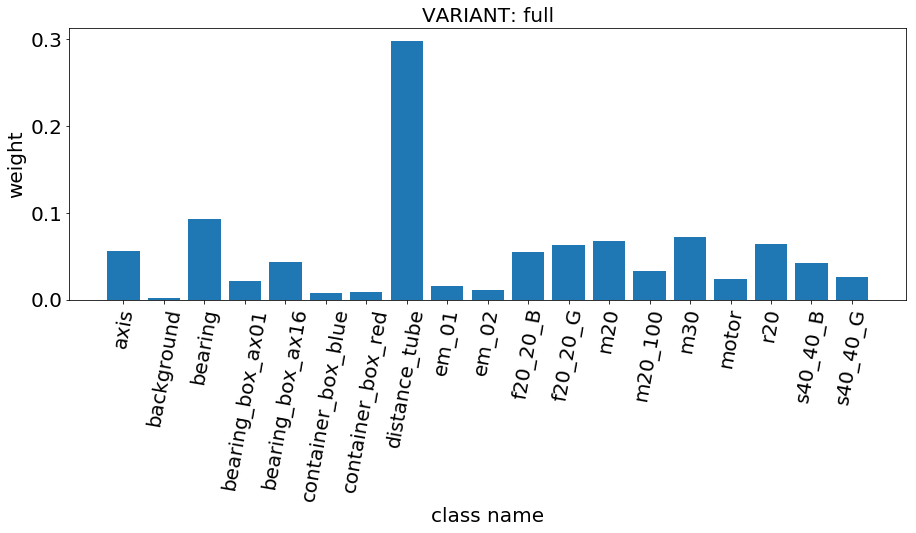

In [6]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: ')
print ()
print (cls_to_weight)
print ()
print ('List of weights: ', list(cls_to_weight.values()))
print ()
print ('List of weights obtained by calling DataAnalysis(): ', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

Count of objects of each class: 

{'background': 7500, 'f20_20_B': 915, 's40_40_B': 909, 'f20_20_G': 799, 's40_40_G': 948, 'm20_100': 1250, 'm20': 1058, 'm30': 940, 'r20': 1003, 'bearing_box_ax01': 1183, 'bearing': 950, 'axis': 1260, 'distance_tube': 820, 'motor': 1143, 'container_box_blue': 1335, 'container_box_red': 1295, 'bearing_box_ax16': 777, 'em_01': 1205, 'em_02': 1355}


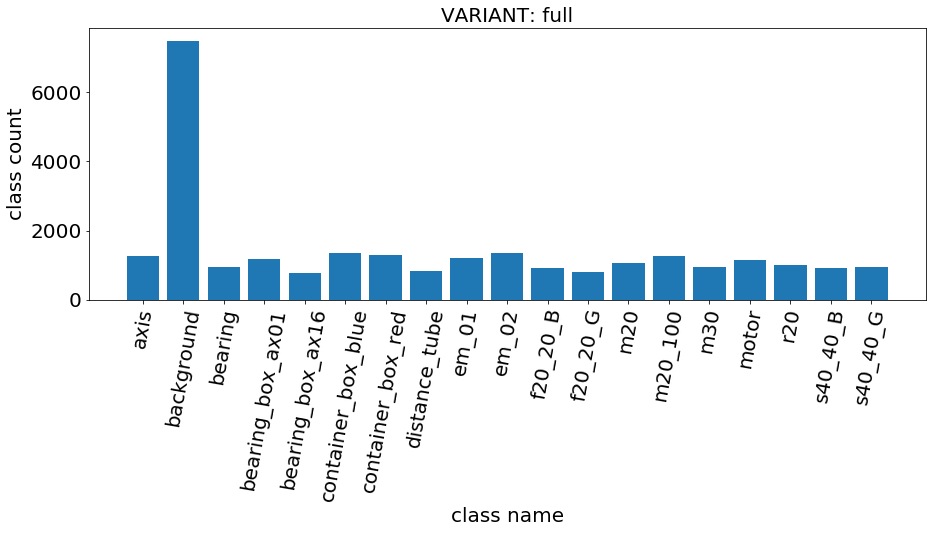

In [7]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: ')
print ()
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')

In [9]:
analyzer = DataAnalysis(VARIANT='similar', LABEL_PATH='./real_augmented/training/label_similar')

Percentage of pixels occupied by each class: 

{'background': 87.88899735243055, 'f/s20/40_20/40_B/G': 1.6429667100694445, 'm20_100': 0.5276860243055556, 'm20/30': 0.48666692708333337, 'r20': 0.2677448784722222, 'bearing_box': 1.1824376302083333, 'bearing': 0.18473910590277778, 'axis': 0.30401085069444445, 'distance_tube': 0.05724079861111111, 'motor': 0.7381453559027777, 'container': 4.058064496527778, 'em_01': 1.1154346354166667, 'em_02': 1.5458652343750001}


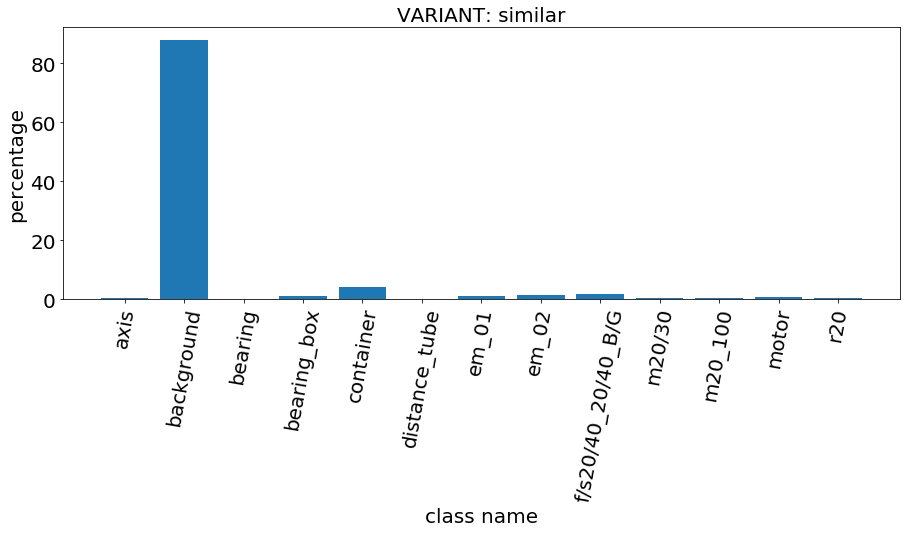

In [10]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: ')
print ()
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

Calculated weight coefficient of each class: 

{'background': 0.0015, 'f/s20/40_20/40_B/G': 0.0158, 'm20_100': 0.0492, 'm20/30': 0.0533, 'r20': 0.097, 'bearing_box': 0.022, 'bearing': 0.1406, 'axis': 0.0854, 'distance_tube': 0.4536, 'motor': 0.0352, 'container': 0.0064, 'em_01': 0.0233, 'em_02': 0.0168}

List of weights:  [0.0015, 0.0158, 0.0492, 0.0533, 0.097, 0.022, 0.1406, 0.0854, 0.4536, 0.0352, 0.0064, 0.0233, 0.0168]

List of weights obtained by calling DataAnalysis():  [0.0015, 0.0158, 0.0492, 0.0533, 0.097, 0.022, 0.1406, 0.0854, 0.4536, 0.0352, 0.0064, 0.0233, 0.0168]


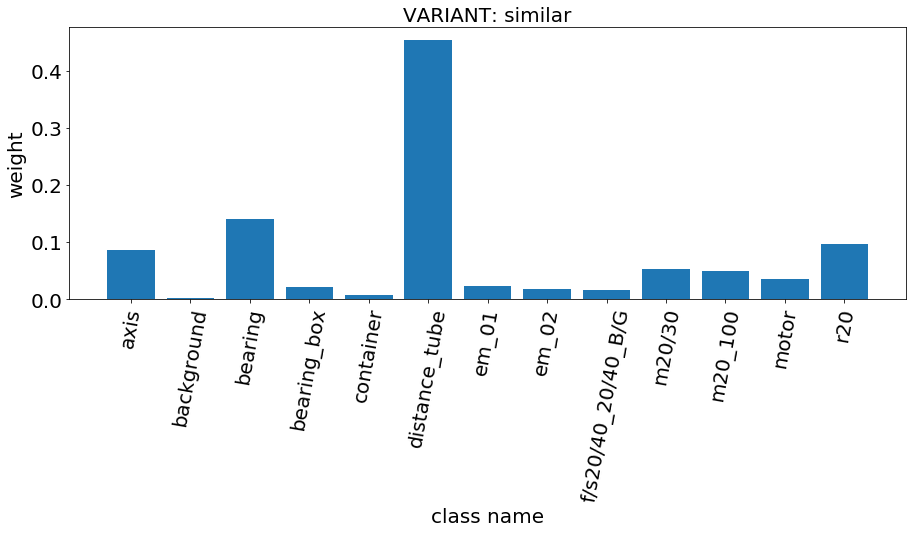

In [11]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: ')
print ()
print (cls_to_weight)
print ()
print ('List of weights: ', list(cls_to_weight.values()))
print ()
print ('List of weights obtained by calling DataAnalysis(): ', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

Count of objects of each class: 

{'background': 7500, 'f/s20/40_20/40_B/G': 3007, 'm20_100': 1250, 'm20/30': 1868, 'r20': 1003, 'bearing_box': 1832, 'bearing': 950, 'axis': 1260, 'distance_tube': 820, 'motor': 1143, 'container': 2445, 'em_01': 1205, 'em_02': 1355}


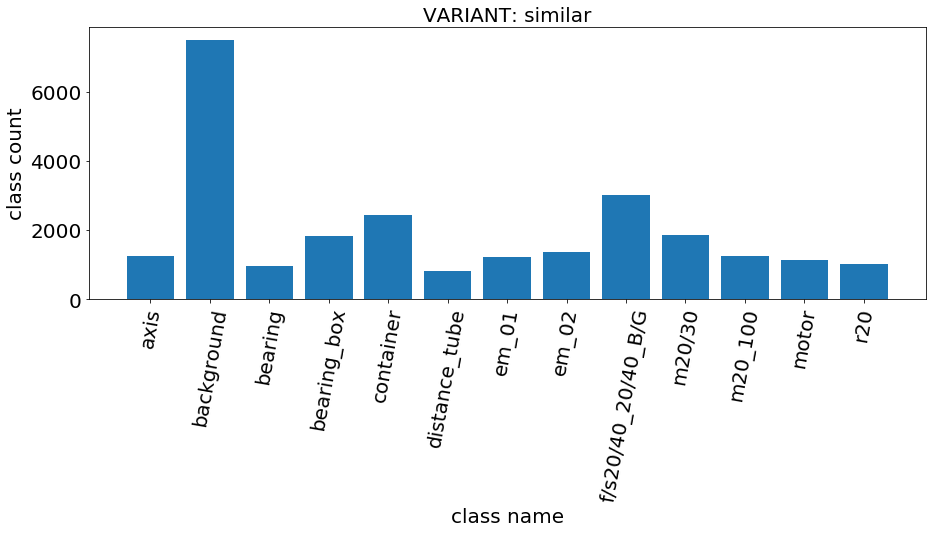

In [12]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: ')
print ()
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')

In [13]:
analyzer = DataAnalysis(VARIANT='size_invariant', LABEL_PATH='./real_augmented/training/label_size_invariant')

Percentage of pixels occupied by each class: 

{'background': 87.88899735243055, 'f/s20/40_20/40_B': 0.7225475694444444, 'f/s20/40_20/40_G': 0.920419140625, 'm20_100': 0.5276860243055556, 'm20/30': 0.48666692708333337, 'r20': 0.2677448784722222, 'bearing_box': 1.1824376302083333, 'bearing': 0.18473910590277778, 'axis': 0.30401085069444445, 'distance_tube': 0.05724079861111111, 'motor': 0.7381453559027777, 'container_box_blue': 2.1301194010416666, 'container_box_red': 1.927945095486111, 'em_01': 1.1154346354166667, 'em_02': 1.5458652343750001}


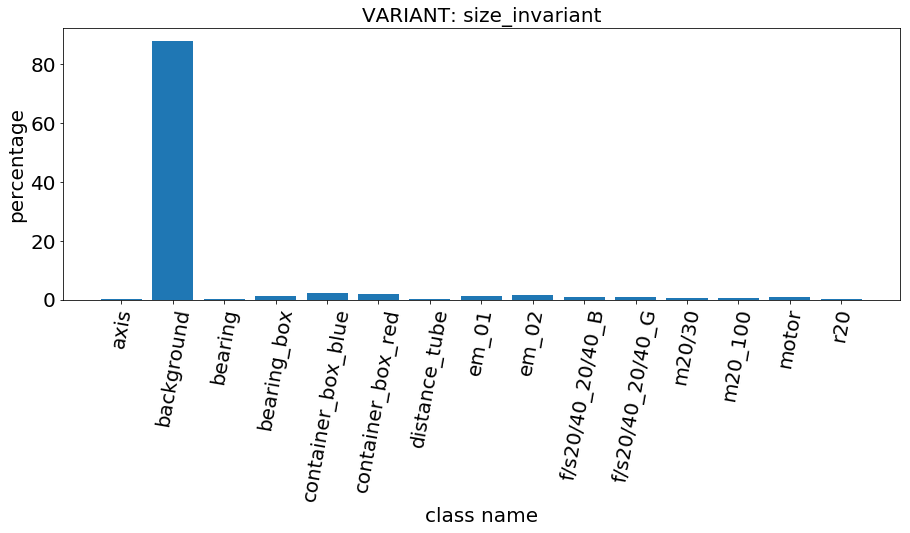

In [14]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: ')
print ()
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

Calculated weight coefficient of each class: 

{'background': 0.0017, 'f/s20/40_20/40_B': 0.0336, 'f/s20/40_20/40_G': 0.0264, 'm20_100': 0.0461, 'm20/30': 0.05, 'r20': 0.0908, 'bearing_box': 0.0206, 'bearing': 0.1316, 'axis': 0.08, 'distance_tube': 0.4248, 'motor': 0.0329, 'container_box_blue': 0.0114, 'container_box_red': 0.0126, 'em_01': 0.0218, 'em_02': 0.0157}

List of weights:  [0.0017, 0.0336, 0.0264, 0.0461, 0.05, 0.0908, 0.0206, 0.1316, 0.08, 0.4248, 0.0329, 0.0114, 0.0126, 0.0218, 0.0157]

List of weights obtained by calling DataAnalysis():  [0.0017, 0.0336, 0.0264, 0.0461, 0.05, 0.0908, 0.0206, 0.1316, 0.08, 0.4248, 0.0329, 0.0114, 0.0126, 0.0218, 0.0157]


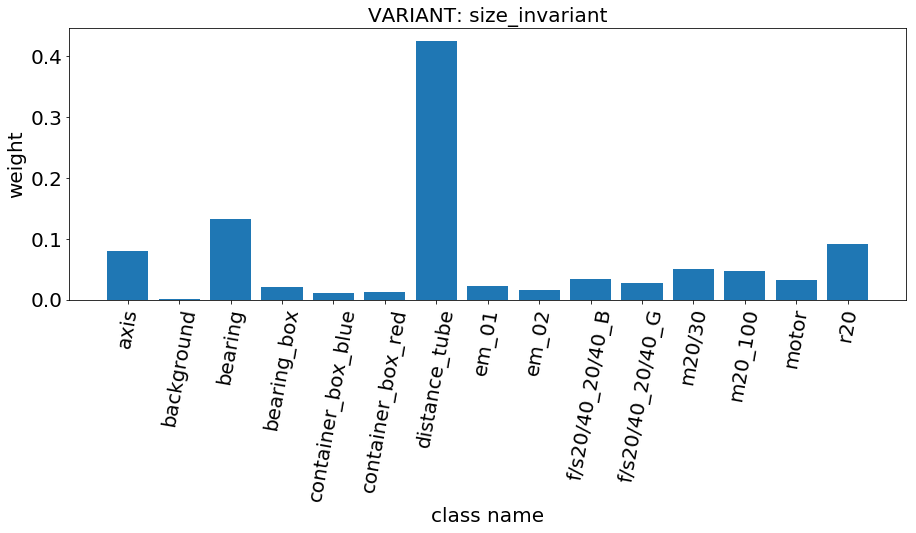

In [15]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: ')
print ()
print (cls_to_weight)
print ()
print ('List of weights: ', list(cls_to_weight.values()))
print ()
print ('List of weights obtained by calling DataAnalysis(): ', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

Count of objects of each class: 

{'background': 7500, 'f/s20/40_20/40_B': 1726, 'f/s20/40_20/40_G': 1653, 'm20_100': 1250, 'm20/30': 1868, 'r20': 1003, 'bearing_box': 1832, 'bearing': 950, 'axis': 1260, 'distance_tube': 820, 'motor': 1143, 'container_box_blue': 1335, 'container_box_red': 1295, 'em_01': 1205, 'em_02': 1355}


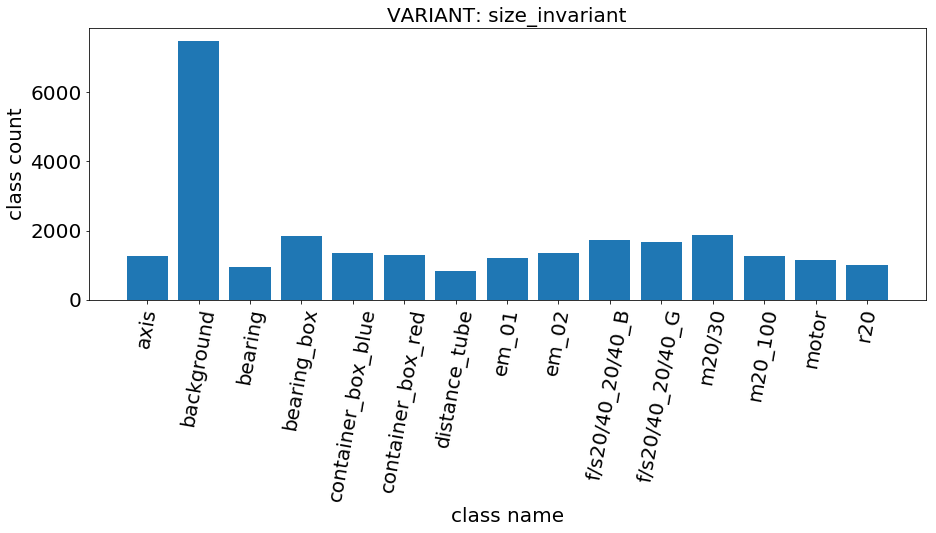

In [16]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: ')
print ()
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')

In [17]:
analyzer = DataAnalysis(VARIANT='binary', LABEL_PATH='./real_augmented/training/label_binary')

Percentage of pixels occupied by each class: 

{'background': 87.88899735243055, 'foreground': 12.111002647569444}


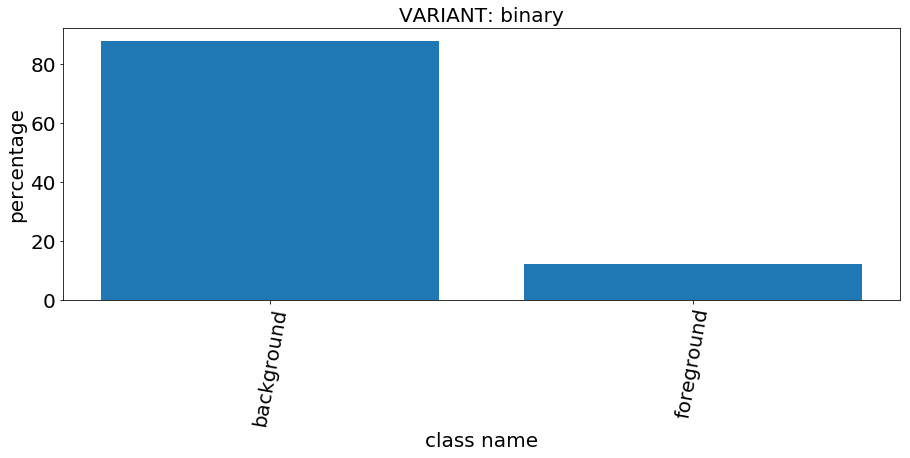

In [18]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: ')
print ()
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

Calculated weight coefficient of each class: 

{'background': 0.0002, 'foreground': 0.9998}

List of weights:  [0.0002, 0.9998]

List of weights obtained by calling DataAnalysis():  [0.0002, 0.9998]


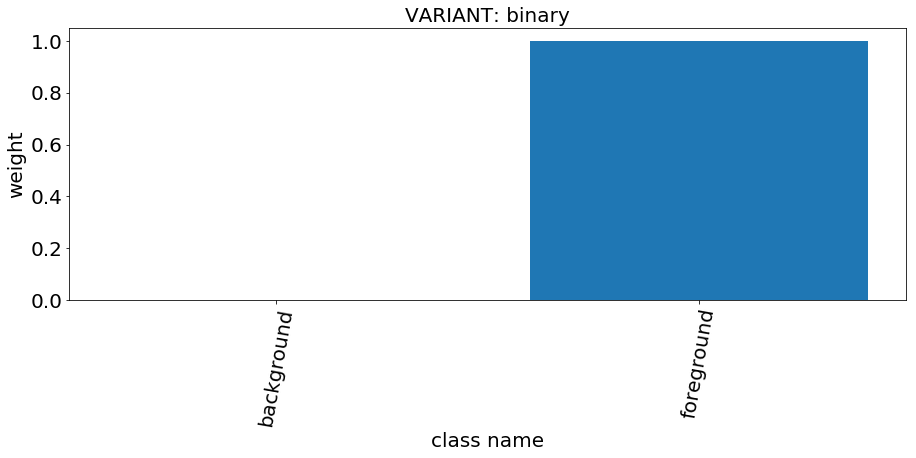

In [19]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: ')
print ()
print (cls_to_weight)
print ()
print ('List of weights: ', list(cls_to_weight.values()))
print ()
print ('List of weights obtained by calling DataAnalysis(): ', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

Count of objects of each class: 

{'background': 7500, 'foreground': 7499}


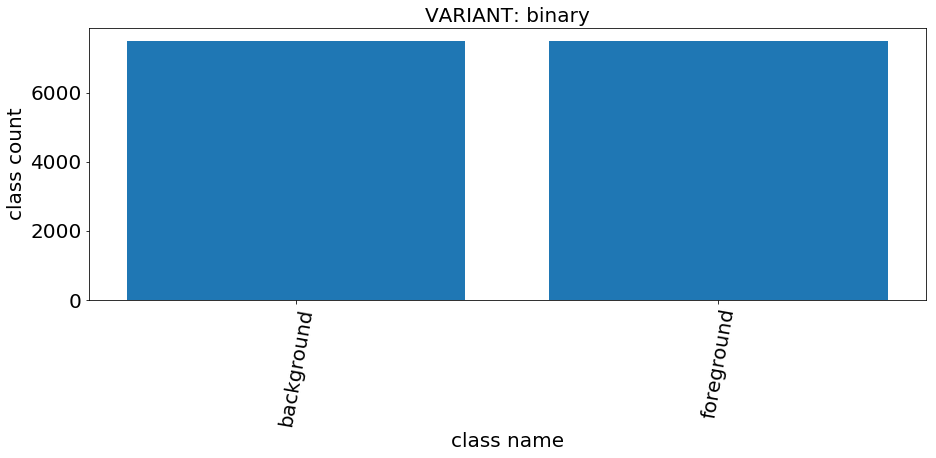

In [20]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: ')
print ()
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')